In [1]:
import os, torch
import json
from PIL import Image
import pandas as pd, numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt

# CustomDataset

In [2]:

class CustomDataset(Dataset):
    
    def __init__(self, root, transformations=None):
        self.transformations = transformations
        self.meta_data = self.load_metadata(root)
        self.cls_names = self.class_names(root)
        
    def load_metadata(self, root):
        meta_data = {}
        meta_path = os.path.join(root, "meta_deta.csv")
        df = pd.read_csv(meta_path)
        for _, row in df.iterrows():
            image_id = row["image_id"]
            label = row["label"]
            image_path = os.path.join(root, "images", image_id)
            if os.path.isfile(image_path):
                meta_data[image_path] = label
        return meta_data
    
    def class_names(self, root):
        cl_names = {}
        with open(os.path.join(root, "class_names.json")) as f:
            cl_json = json.load(f)
            cl_names = {int(key): value for key, value in cl_json.items()}
        return cl_names
    
    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        image_path = list(self.meta_data.keys())[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.meta_data[image_path]
        
        if self.transformations:
            image = self.transformations(image)
        
        return image, label
    
tfs = T.Compose([T.ToTensor()])   
root = "/kaggle/input/crop-disease-image-classification-dataset/crop_disease_dataset"   
ds = CustomDataset(root=root, transformations=tfs) 


In [3]:
ds.cls_names

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

# Visualize

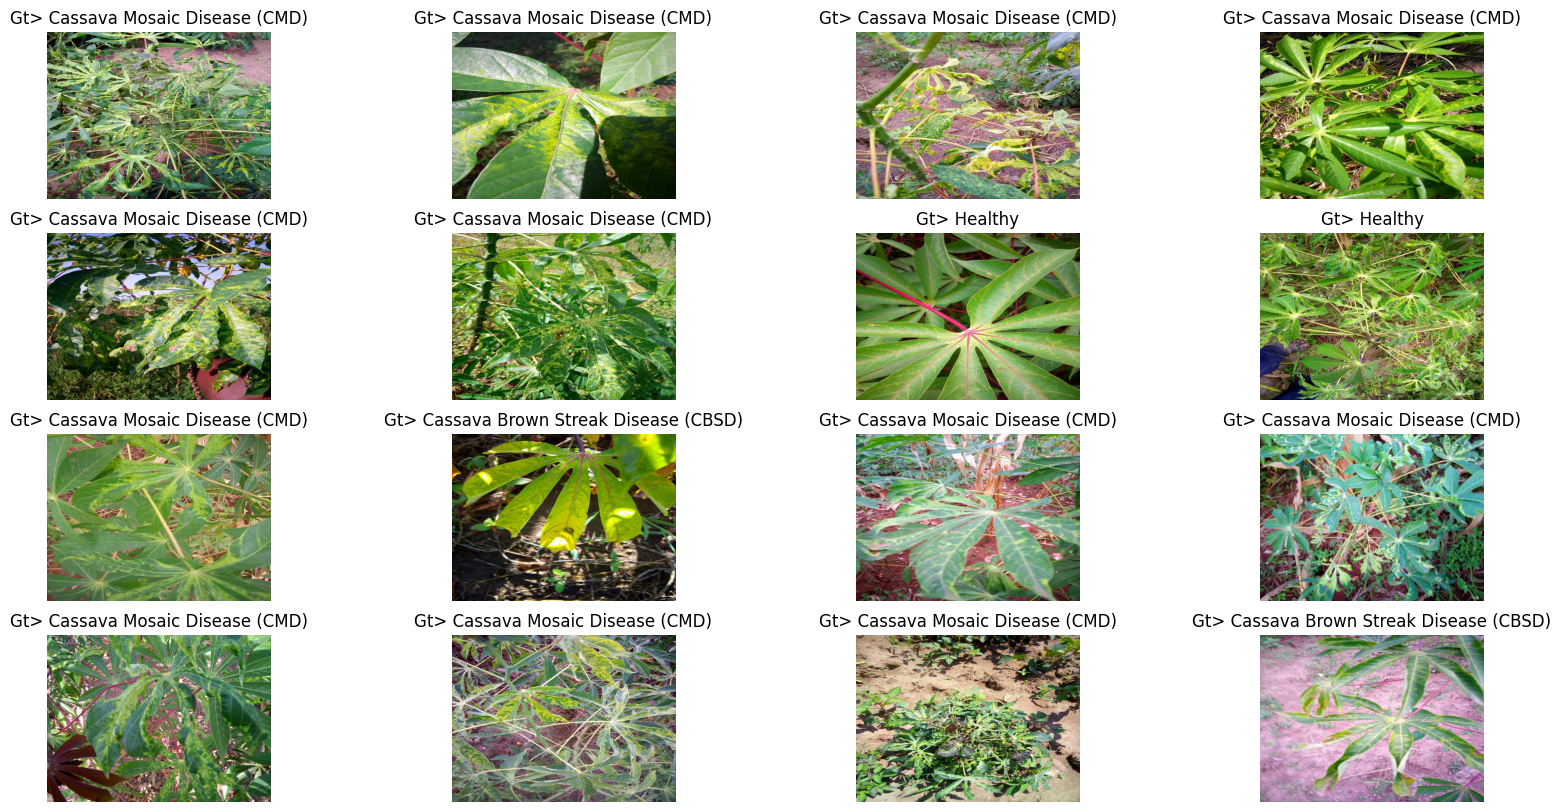

In [4]:
def visualize(rows, im_num):
    

    def tensor_2_im(tensor, color_mode="rgb"):
        gray_transforms = T.Compose([
            T.Normalize(mean=[0.], std=[1/0.5]),
            T.Normalize(mean=[-0.5], std=[1])
        ])
        rgb_transforms = T.Compose([
                T.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
#         T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
#         T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
        
        ])
        inverse_transform = gray_transforms if color_mode.lower() == "gray" else rgb_transforms    
        image = (inverse_transform(tensor) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
        return image



    indices = np.random.randint(low=0, high=len(ds), size=im_num)

    plt.figure(figsize=(20,10))
    for i, idx in enumerate(indices):
        im, lb = ds[idx]
        class_name = ds.cls_names[lb]
        plt.subplot(rows, im_num // rows, i+1)
        plt.imshow(tensor_2_im(im))
        plt.title(f'Gt> {class_name}')
        plt.axis('off')
visualize(4, 16)
        


# Split_Data

In [5]:
def dataloader(root, transformation, batch, split = [0.8, 0.1, 0.1]):
    assert sum(split)==1
    
    ds = CustomDataset(root=root, transformations=tfs)
    
    tr_len = int(split[0] * len(ds))
    val_len = int(split[1] * len(ds))
    test_len = len(ds) - (tr_len + val_len)
    
    # Data split
    
    tr_ds, vl_ds, ts_ds = random_split(ds, [tr_len, val_len, test_len])
    
    print(f'Trainset: {len(tr_ds)}')
    print(f'Validationset: {len(vl_ds)}')
    print(f'Testset: {len(ts_ds)}')
    
    
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch, shuffle=True)
    val_dl = DataLoader(dataset=vl_ds, batch_size=batch, shuffle=False)
    test_dl = DataLoader(dataset=ts_ds,batch_size= 1, shuffle=False)
    
    return tr_dl, val_dl, test_dl
    
tr_dl, val_dl, test_dl = dataloader(root=root, batch=32, transformation=tfs)
print("\n")

print(f'Train_dl: {len(tr_dl)}')
print(f'Val_dl: {len(val_dl)}')
print(f'Test_dl: {len(test_dl)}')

Trainset: 14350
Validationset: 1793
Testset: 1795


Train_dl: 449
Val_dl: 57
Test_dl: 1795


# Training Setup

In [6]:
import timm
import torch.nn as nn
#timm.list_models('inception*')
# Load the pretrained data
model = timm.create_model('resnet18', pretrained=True)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [7]:
def train_setup(model): 
    return model.to("cuda"), 12, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = model.parameters(), lr = 3e-5)

model, epochs, device, loss_fn, optimizer = train_setup(model)

In [8]:
from tqdm import tqdm
import os

def train(model, device, epochs, tr_dl, val_dl, loss_fn, optimizer, checkpoint_path):
    patience = 4
    best_val_loss = float("inf")
    best_val_acc = 0
    improvement = 0

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        epoch_loss, epoch_acc, total = 0, 0, 0

        model.train()
        for idx, batch in enumerate(tqdm(tr_dl)):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            total += ims.shape[0]

            preds = model(ims)
            loss = loss_fn(preds, gts)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            _, pred_cls = torch.max(preds.data, dim=1)
            epoch_acc += (pred_cls == gts).sum().item()
            epoch_loss += loss.item()

        tr_loss = epoch_loss / len(tr_dl)
        train_losses.append(tr_loss)
        train_accs.append(epoch_acc / total)

        print(f"Epoch {epoch + 1} train process is finished")
        print(f"Epoch {epoch + 1} train loss -> {train_losses[epoch]:.3f}")
        print(f"Epoch {epoch + 1} train accuracy -> {train_accs[epoch]:.3f}")

        model.eval()
        with torch.no_grad():
            val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0
            for idx, batch in enumerate(val_dl):
                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)
                val_total += ims.shape[0]

                preds = model(ims)
                loss = loss_fn(preds, gts)

                _, pred_cls = torch.max(preds.data, dim=1)
                val_epoch_acc += (pred_cls == gts).sum().item()
                val_epoch_loss += loss.item()

            val_loss = val_epoch_loss / len(val_dl)
            val_acc = val_epoch_acc / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"Epoch {epoch + 1} validation is finished")
            print(f"Epoch {epoch + 1} validation loss -> {val_losses[epoch]:.3f}")
            print(f"Epoch {epoch + 1} validation accuracy -> {val_accs[epoch]:.3f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                improvement = 0

                # Save the checkpoint
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_losses,
                    'train_acc': train_accs,
                    'val_loss': val_losses,
                    'val_acc': val_accs
                }
                torch.save(checkpoint, checkpoint_path)
            else:
                improvement += 1
                if improvement >= patience:
                    print(f"No improvement in validation loss for {patience} epochs. Stopping early.")
                    break

    return train_losses, train_accs, val_losses, val_accs


checkpoint_path = '/kaggle/working/model_checkpoint.pth'


train_losses, train_accs, val_losses, val_accs = train(model=model, device=device, epochs=epochs, tr_dl=tr_dl, val_dl=val_dl, loss_fn=loss_fn, optimizer=optimizer, checkpoint_path=checkpoint_path)


100%|██████████| 449/449 [09:22<00:00,  1.25s/it]


Epoch 1 train process is finished
Epoch 1 train loss -> 3.340
Epoch 1 train accuracy -> 0.499
Epoch 1 validation is finished
Epoch 1 validation loss -> 1.080
Epoch 1 validation accuracy -> 0.708


100%|██████████| 449/449 [08:55<00:00,  1.19s/it]


Epoch 2 train process is finished
Epoch 2 train loss -> 0.823
Epoch 2 train accuracy -> 0.742
Epoch 2 validation is finished
Epoch 2 validation loss -> 0.626
Epoch 2 validation accuracy -> 0.797


100%|██████████| 449/449 [08:57<00:00,  1.20s/it]


Epoch 3 train process is finished
Epoch 3 train loss -> 0.590
Epoch 3 train accuracy -> 0.802
Epoch 3 validation is finished
Epoch 3 validation loss -> 0.517
Epoch 3 validation accuracy -> 0.830


100%|██████████| 449/449 [08:53<00:00,  1.19s/it]


Epoch 4 train process is finished
Epoch 4 train loss -> 0.503
Epoch 4 train accuracy -> 0.830
Epoch 4 validation is finished
Epoch 4 validation loss -> 0.467
Epoch 4 validation accuracy -> 0.842


100%|██████████| 449/449 [08:51<00:00,  1.18s/it]


Epoch 5 train process is finished
Epoch 5 train loss -> 0.452
Epoch 5 train accuracy -> 0.847
Epoch 5 validation is finished
Epoch 5 validation loss -> 0.446
Epoch 5 validation accuracy -> 0.847


100%|██████████| 449/449 [08:53<00:00,  1.19s/it]


Epoch 6 train process is finished
Epoch 6 train loss -> 0.415
Epoch 6 train accuracy -> 0.860
Epoch 6 validation is finished
Epoch 6 validation loss -> 0.433
Epoch 6 validation accuracy -> 0.853


100%|██████████| 449/449 [08:55<00:00,  1.19s/it]


Epoch 7 train process is finished
Epoch 7 train loss -> 0.388
Epoch 7 train accuracy -> 0.869
Epoch 7 validation is finished
Epoch 7 validation loss -> 0.418
Epoch 7 validation accuracy -> 0.865


100%|██████████| 449/449 [08:55<00:00,  1.19s/it]


Epoch 8 train process is finished
Epoch 8 train loss -> 0.359
Epoch 8 train accuracy -> 0.880
Epoch 8 validation is finished
Epoch 8 validation loss -> 0.412
Epoch 8 validation accuracy -> 0.862


100%|██████████| 449/449 [08:58<00:00,  1.20s/it]


Epoch 9 train process is finished
Epoch 9 train loss -> 0.335
Epoch 9 train accuracy -> 0.886
Epoch 9 validation is finished
Epoch 9 validation loss -> 0.410
Epoch 9 validation accuracy -> 0.866


100%|██████████| 449/449 [09:01<00:00,  1.21s/it]


Epoch 10 train process is finished
Epoch 10 train loss -> 0.315
Epoch 10 train accuracy -> 0.895
Epoch 10 validation is finished
Epoch 10 validation loss -> 0.408
Epoch 10 validation accuracy -> 0.868


100%|██████████| 449/449 [08:59<00:00,  1.20s/it]


Epoch 11 train process is finished
Epoch 11 train loss -> 0.294
Epoch 11 train accuracy -> 0.903
Epoch 11 validation is finished
Epoch 11 validation loss -> 0.403
Epoch 11 validation accuracy -> 0.867


100%|██████████| 449/449 [08:56<00:00,  1.20s/it]


Epoch 12 train process is finished
Epoch 12 train loss -> 0.265
Epoch 12 train accuracy -> 0.914
Epoch 12 validation is finished
Epoch 12 validation loss -> 0.404
Epoch 12 validation accuracy -> 0.869


# Plotting Learning curves

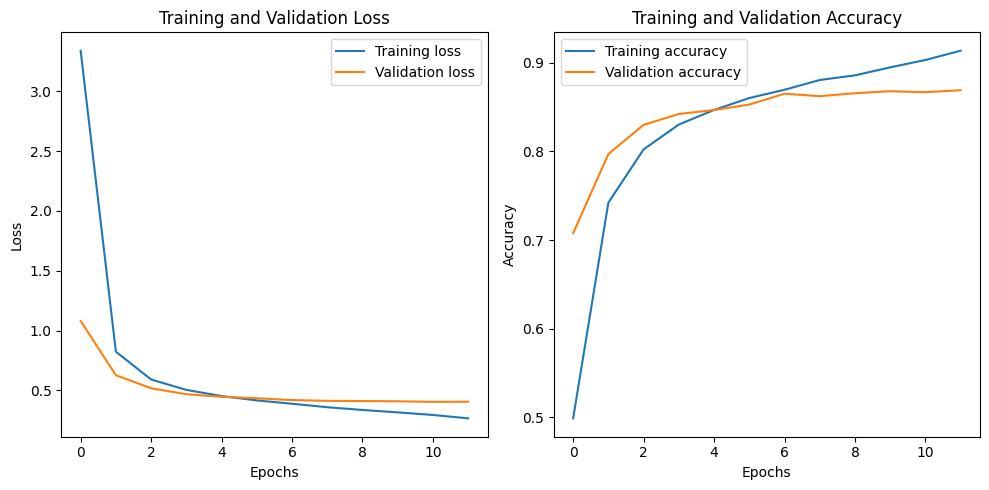

In [10]:
import matplotlib.pyplot as plt

def plot_results():
    

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()
    
plot_results()

# Inference

In [11]:
!pip install grad-cam==1.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38239 sha256=c4ee3e2e583cddb51e221af0189478e314d7090248ec115d38a892a5235dda0f
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam


In [16]:
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

def tensor_2_im(t, type = "rgb"):
    gray = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb = T.Compose([T.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])
#     rgb = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.2505, 1/0.2505, 1/0.2505]),
#                          T.Normalize(mean = [ -0.2250, -0.2250, -0.2250 ], std = [ 1., 1., 1. ])])
    inp = gray if type == "gray" else rgb
    return(inp(t)*255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if type == "gray" else (inp(t)*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

100%|██████████| 1795/1795 [00:30<00:00, 58.52it/s]


Accuracy of the model on the test dataset ->  0.879


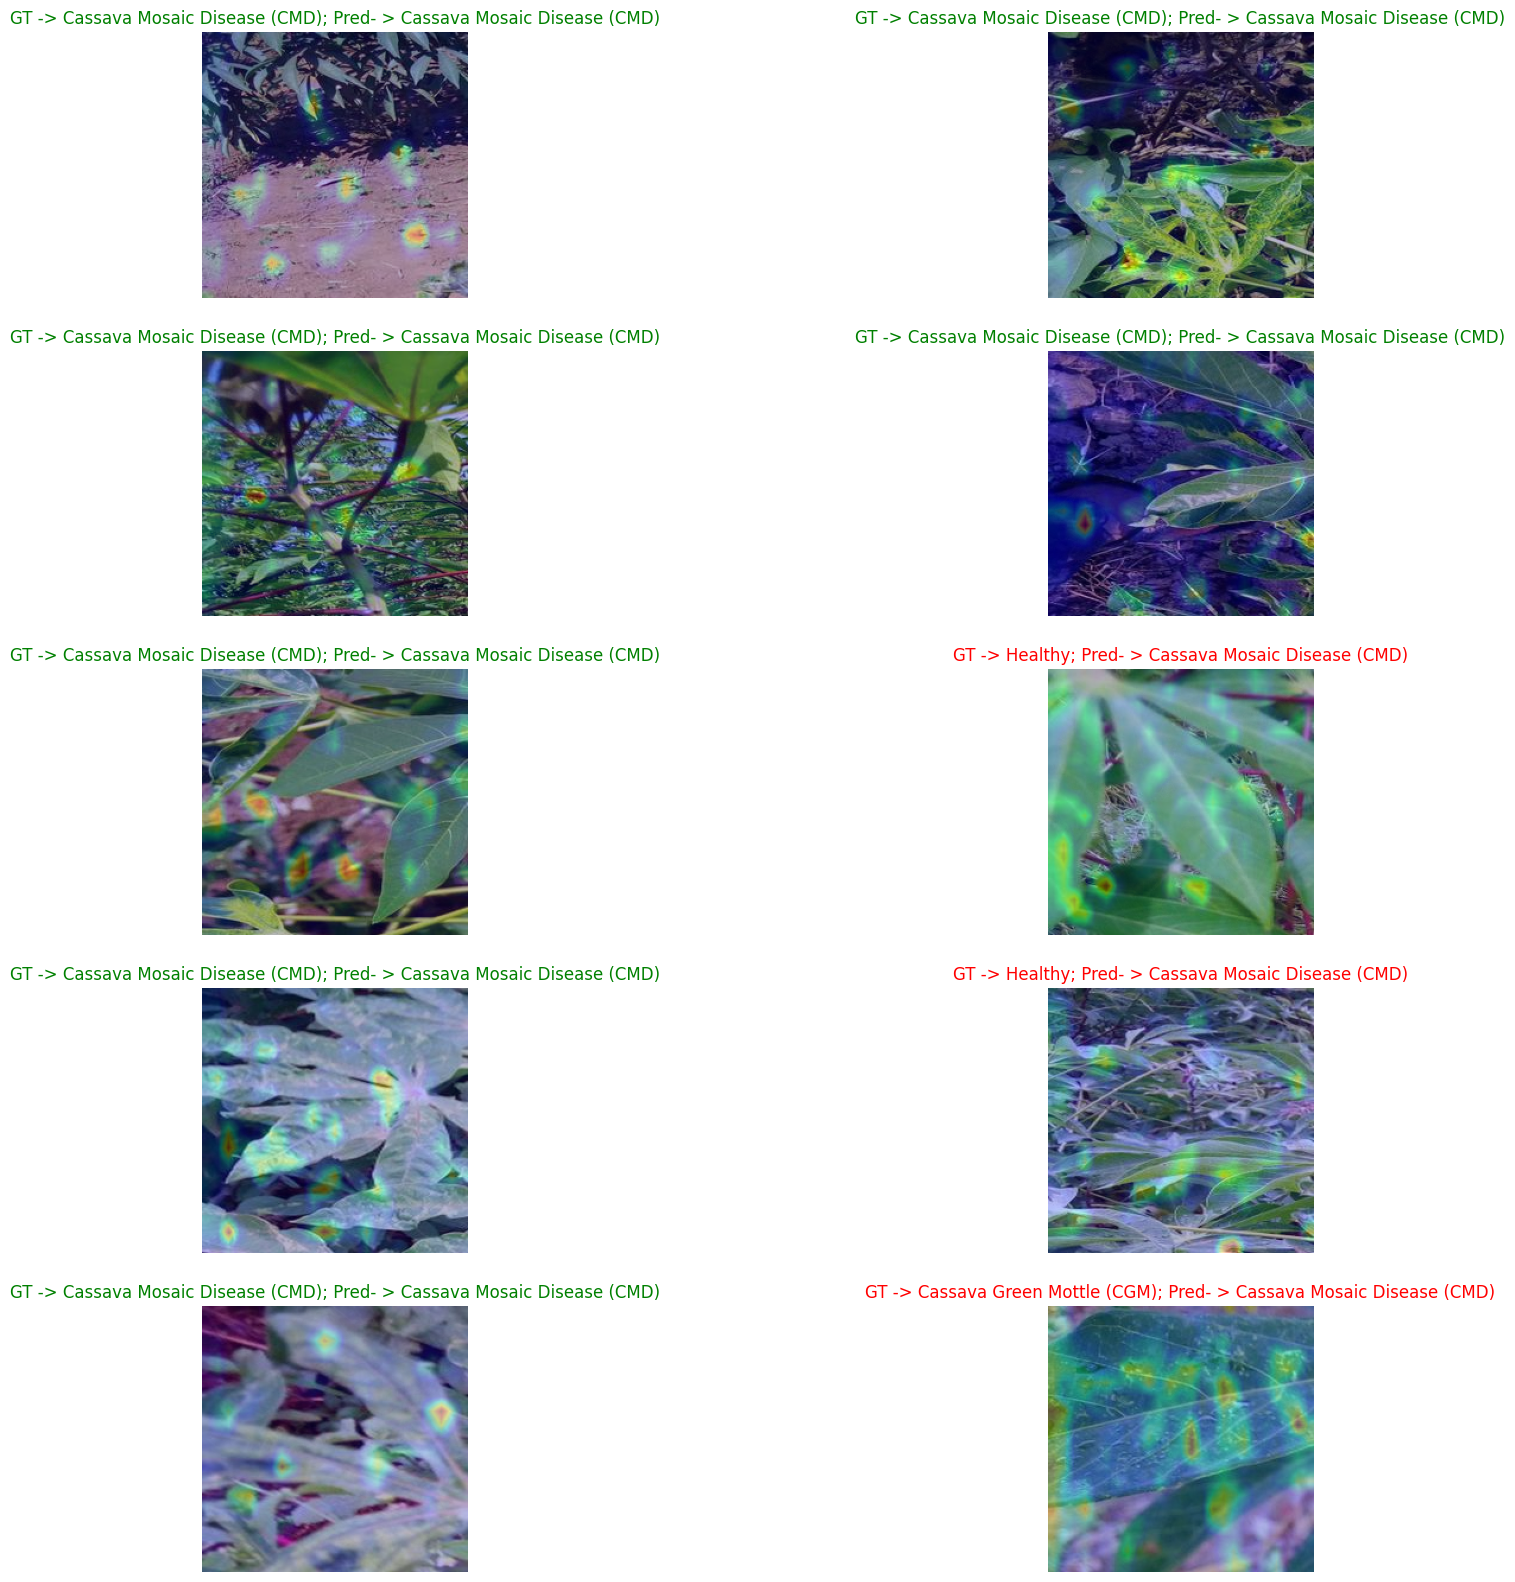

In [21]:
import random

def inference(model, device, data, num_im, row, class_name=None, im_dim=None):
    model.eval()  # Set model to evaluation mode
    Acc = 0
    preds, ims, gts = [], [], []
    
    # Accumulate predictions
    for idx, batch in enumerate(tqdm(data)):
        im, gt = batch
        im, gt = im.to(device), gt.to(device)
        pred = model(im)

        pred_class = torch.argmax(pred, dim=1)
        Acc += (pred_class == gt).sum().item()
        ims.append(im)
        preds.append(pred_class)
        #preds.append(pred_class.item())
        #gts.append(gt.item())
        gts.append(gt)

    # Print accuracy
    print(f"Accuracy of the model on the test dataset -> {Acc / len(data): .3f}")
    
    # Generate random indices for image selection
    indices = random.sample(range(len(ims)), min(num_im, len(ims)))
    
    # Plot images
    plt.figure(figsize=(20, 20))
    for i, idx in enumerate(indices):
        im = ims[idx].squeeze()
        gt = gts[idx]
        pred = preds[idx]

        # GradCAM
        orginal_im = tensor_2_im(im) / 255
        cam = GradCAMPlusPlus(model=model, target_layers=[model.layer4[-1]])
        grayscale_cam = cam(input_tensor=im.unsqueeze(0))[0, :]
        heat_map = show_cam_on_image(img=orginal_im, mask=grayscale_cam, image_weight=0.1, use_rgb="jet")

        # Plot image with GradCAM overlay
        plt.subplot(row, num_im // row, i + 1)
        plt.imshow(tensor_2_im(im), cmap="gray")
        plt.axis("off")
        plt.imshow(cv2.resize(heat_map, (im_dim, im_dim), interpolation=cv2.INTER_LINEAR), alpha=0.3, cmap='jet')
        plt.axis("off")
        color = ("green" if class_name[int(gt.item())] == class_name[int(pred_class.item())] else 'red')
        if class_name:
            plt.title(f"GT -> {class_name[int(gt.item())]}; Pred- > {class_name[int(pred_class.item())]}", color=color)
        else:
            plt.title(f"GT -> {gt.item()}; PRED -> {pred.item()}")

# Load the model from the checkpoint
checkpoint = torch.load("/kaggle/working/model_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])          
inference(model.to(device), device, test_dl, 10, 5, ds.cls_names, 224)
